In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/34 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N20.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N1.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/49 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N15.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/No18.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/31 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 6.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/3 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 5.jpeg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 1.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/26 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N26.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N5.jpg
/kaggle/input/brain-mri-images-for-b

In [2]:
# Import Libraries
# For Preprocessing
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

# For Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers


2025-10-02 10:38:31.967229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759401512.163298      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759401512.221565      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
folder_data = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"
Path = []
Labels = []

#to get the path for each Img :

folders_path = os.listdir(folder_data)
for img in folders_path : 
    FolderPath = os.path.join(folder_data, img)
    FolderName = os.listdir(FolderPath)
    for path in FolderName :
        Images_path = os.path.join(FolderPath, path)
        
        Path.append(Images_path)
        Labels.append(img)

# Concatenate paths with labels into one dataframe        
Pseries = pd.Series(Path, name = "Img_Path")
Lseries = pd.Series(Labels, name = "Img_label")
df = pd.concat([Pseries, Lseries], axis=1)

In [4]:
df

,Img_Path,Img_label
0,/kaggle/input/brain-mri-images-for-brain-tumor...,no
1,/kaggle/input/brain-mri-images-for-brain-tumor...,no
2,/kaggle/input/brain-mri-images-for-brain-tumor...,no
3,/kaggle/input/brain-mri-images-for-brain-tumor...,no
4,/kaggle/input/brain-mri-images-for-brain-tumor...,no
...,...,...
250,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
251,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
252,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
253,/kaggle/input/brain-mri-images-for-brain-tumor...,brain_tumor_dataset


In [5]:
# Split data ( Train , Test , Valid)
st = df['Img_label']
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= st)

In [6]:
# Create Image Data Generator
# Crob image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'Img_Path', y_col= 'Img_label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'Img_Path', y_col= 'Img_label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


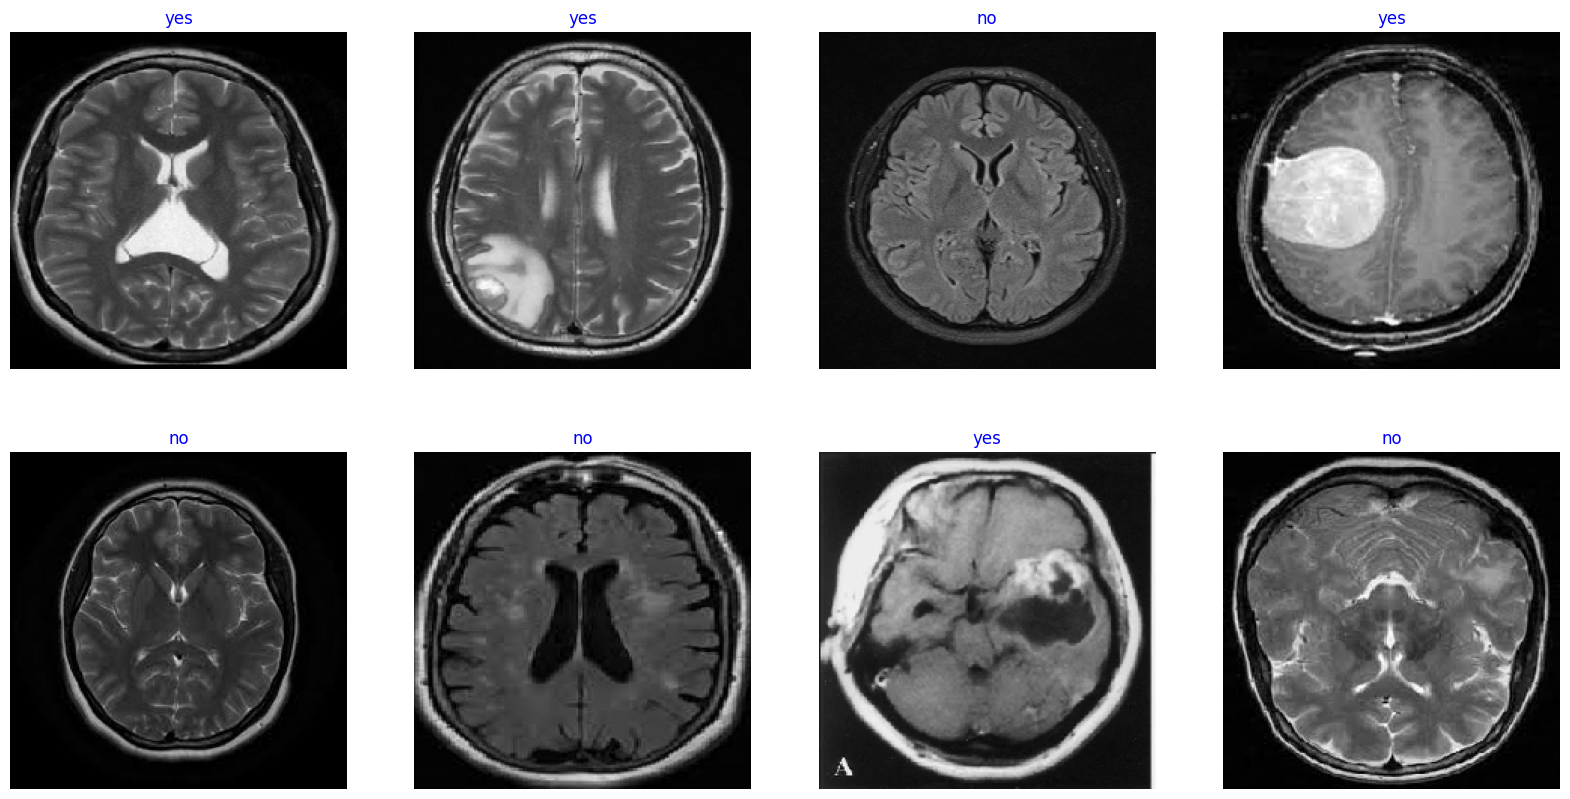

In [7]:
# Show Samples From Train data
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 10))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i] / 255     # scale data (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

## EfficientNetB3 

In [8]:
# Create Model 
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (efficientnet, VGG , Resnet )
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet",input_shape= img_shape, pooling= 'max')


model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006), bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

I0000 00:00:1759401525.798874      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,183,665 (42.66 MB)

 Trainable params: 11,093,290 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

## EfficientNetB3 Training

In [9]:
# Train Model
epochs = 25

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, validation_steps= None, shuffle= False)

Epoch 1/25


I0000 00:00:1759401614.654197      98 service.cc:148] XLA service 0x7b3e9c002fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759401614.656840      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759401621.431735      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1759401632.761694      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759401632.954661      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759401633.398985      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759401633.6155

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7377 - loss: 13.6323

E0000 00:00:1759401681.854894      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759401682.047658      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759401682.476479      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759401682.693548      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


26/26 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.7366 - loss: 13.6014 - val_accuracy: 0.6667 - val_loss: 22.9753
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.8547 - loss: 11.2578 - val_accuracy: 0.7647 - val_loss: 14.8523
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.8592 - loss: 9.3900 - val_accuracy: 0.7647 - val_loss: 12.5906
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.8648 - loss: 7.9309 - val_accuracy: 0.7843 - val_loss: 9.9510
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.8422 - loss: 7.0936 - val_accuracy: 0.8039 - val_loss: 8.2416
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.8474 - loss: 6.6014 - val_accuracy: 0.8824 - val_loss: 7.4204
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.8994 - loss: 6.1768 - val_accuracy: 0.8627 - val_loss: 6.7230
Epoch 8/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.8384 - loss: 5.9546 - val_accuracy: 0.8431 - val_los

In [10]:
 tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

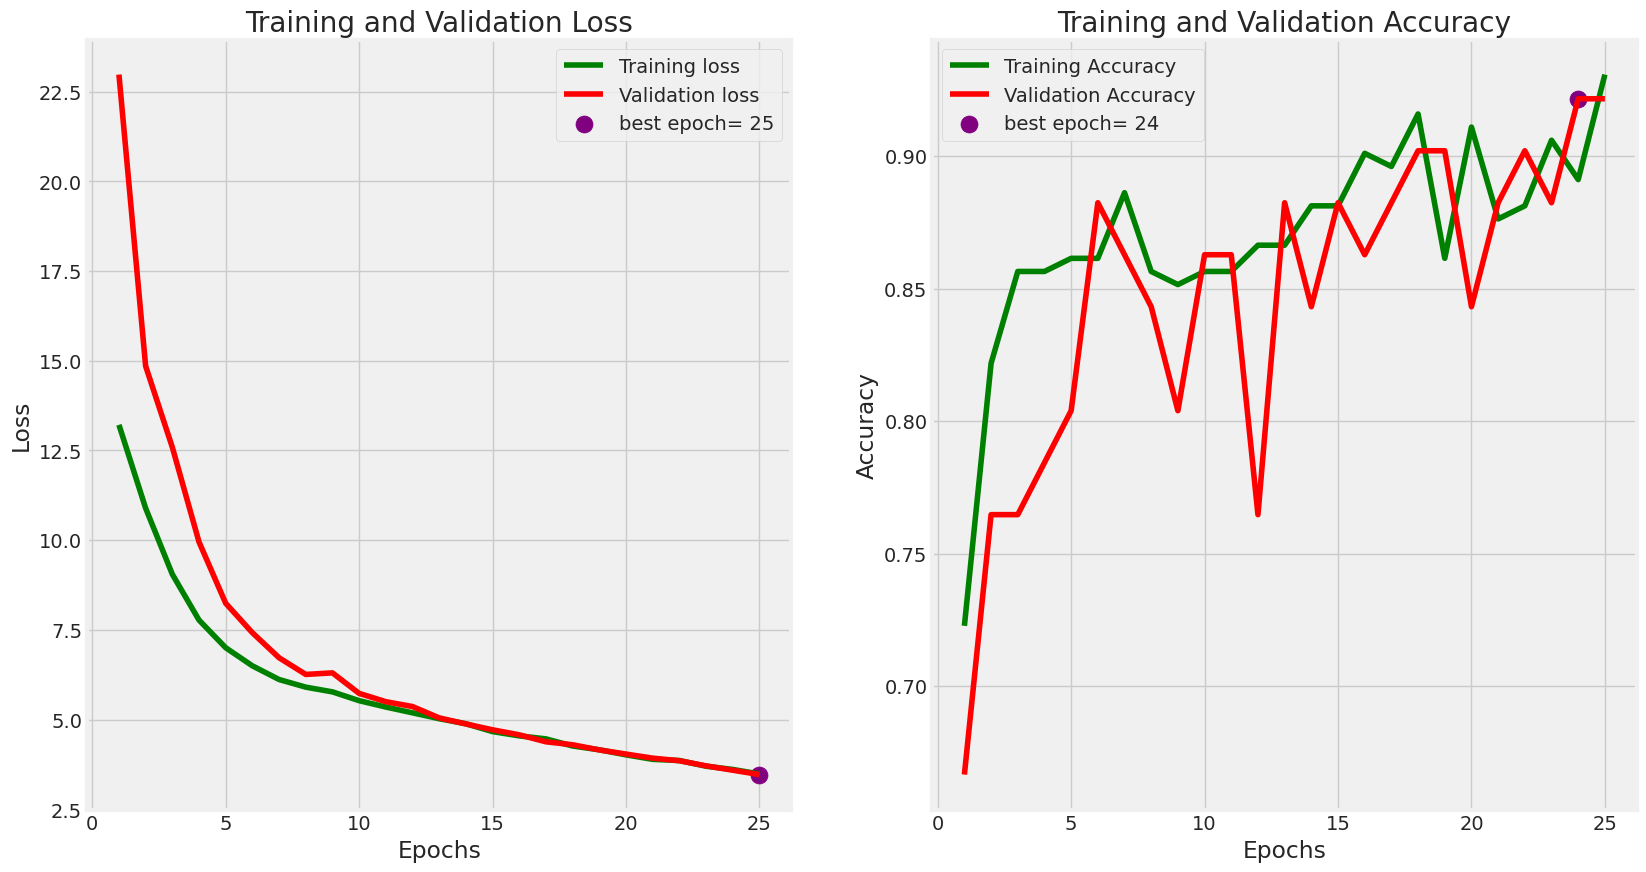

In [11]:
plt.figure(figsize= (20, 10))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'g', label= 'Training loss')
plt.plot(Epochs, val_loss, 'r', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'purple', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'g', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'r', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'purple', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## EfficientNetB3 Evaluation

In [12]:
# Model Evaluation
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 50)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.9955 - loss: 3.3931
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9598 - loss: 3.4361
Train Loss:  3.383207321166992
Train Accuracy:  0.9950494766235352
--------------------------------------------------
Test Loss:  3.4671854972839355
Test Accuracy:  0.9215686321258545


In [13]:
preds = model.predict(test_gen , verbose=1)
y_pred = np.argmax(preds, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step


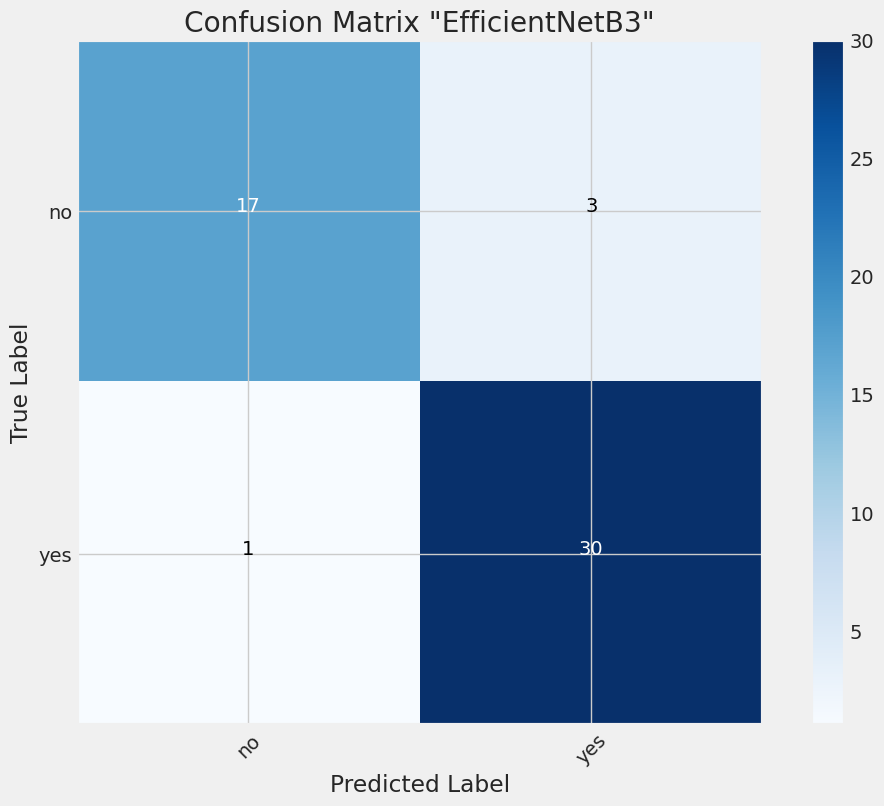

In [14]:
# Confusion Matrix
import itertools
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 8))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix "EfficientNetB3"')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [15]:
# Classification Report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

          no       0.94      0.85      0.89        20
         yes       0.91      0.97      0.94        31

    accuracy                           0.92        51
   macro avg       0.93      0.91      0.92        51
weighted avg       0.92      0.92      0.92        51



## Model saving

In [16]:
model.save('Brain Tumors Classifier EfficientNetB3".h5')

In [17]:
from tensorflow.keras.preprocessing import image
img_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/10 no.jpg"

img = image.load_img(img_path, target_size=(224, 224))  
img_array = image.img_to_array(img) / 255.0              
img_array = np.expand_dims(img_array, axis=0)            

prediction = model.predict(img_array)

if prediction[0][0] > 0.5:
    print("✅ Tumor Detected")
else:
    print("❌ No Tumor Detected")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
❌ No Tumor Detected


## ResNet50

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

BATCH_SIZE = 8
IMG_SIZE = (224, 224)   
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
EPOCHS = 30

# Image Data Generator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [19]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Img_Path',
    y_col='Img_label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',   # one-hot labels
    shuffle=True,
    batch_size=BATCH_SIZE
)

test_gen = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Img_Path',
    y_col='Img_label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False,
    batch_size=BATCH_SIZE
)


Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


In [20]:
print("class_indices:", train_gen.class_indices)
inv_map = {v:k for k,v in train_gen.class_indices.items()}
print("inverse map example:", inv_map)


class_indices: {'no': 0, 'yes': 1}
inverse map example: {0: 'no', 1: 'yes'}


## ResNet50 Structure

In [21]:
from tensorflow.keras import layers, Model
num_classes = len(train_gen.class_indices)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
base_model.trainable = False

inputs = layers.Input(shape=INPUT_SHAPE)
x = preprocess_input(inputs)      
x = base_model(x, training=False)       #  training=False عند استعمال batchnorm في الـ base
x = layers.GlobalAveragePooling2D(name='gap')(x)   # يحول (7,7,channels) -> (channels)
x = layers.BatchNormalization(name='bn')(x)
x = layers.Dense(256, activation='relu', name='fc1')(x)
x = layers.Dropout(0.4, name='dropout')(x)
outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model = Model(inputs, outputs, name='ResNet50_classification_head')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "ResNet50_classification_head"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn                  │ (None, 2048)      │      8,192 │ gap[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc1 (Dense)         │ (None, 256)       │    524,544 │ bn[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ fc1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 2)         │        514 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,120,962 (92.01 MB)

 Trainable params: 529,154 (2.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [22]:
# Callbacks
checkpoint = ModelCheckpoint('best_resnet50.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [23]:
steps_per_epoch = len(train_gen)  
validation_steps = len(test_gen)    

print("steps_per_epoch:", steps_per_epoch, " validation_steps:", validation_steps, type(steps_per_epoch))

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=test_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early, reduce_lr],
    verbose=1
)

steps_per_epoch: 26  validation_steps: 7 <class 'int'>
Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.5041 - loss: 1.0422
Epoch 1: val_accuracy improved from -inf to 0.86275, saving model to best_resnet50.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 543ms/step - accuracy: 0.5070 - loss: 1.0357 - val_accuracy: 0.8627 - val_loss: 0.3798 - learning_rate: 1.0000e-04
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7007 - loss: 0.5518
Epoch 2: val_accuracy improved from 0.86275 to 0.90196, saving model to best_resnet50.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.7019 - loss: 0.5517 - val_accuracy: 0.9020 - val_loss: 0.3072 - learning_rate: 1.0000e-04
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7826 - loss: 0.4712
Epoch 3: val_accuracy improved from 0.90196 to 0.92157, saving model to best_resnet50.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.7835 - loss: 0.4697 - val_accuracy: 0.9216 - val_loss: 0.2800 - learning_rate: 

## ResNet50 Evaluation

In [24]:
train_score = model.evaluate(train_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)


print("ResNet50 Model Performance")
print("-" * 50)
print("Train Loss:     ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("-" * 50)
print("Test Loss:      ", test_score[0])
print("Test Accuracy:  ", test_score[1])

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.9585 - loss: 0.1725
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9453 - loss: 0.1885
ResNet50 Model Performance
--------------------------------------------------
Train Loss:      0.2001170665025711
Train Accuracy:  0.9356435537338257
--------------------------------------------------
Test Loss:       0.23077207803726196
Test Accuracy:   0.9019607901573181


In [25]:
try:                                     ## تخزين أفضل وزن باسم 'best_resnet50.h5'
    model.load_weights('best_resnet50.h5')
    print("Loaded best_resnet50.h5 weights.")
except Exception as e:
    print("No checkpoint loaded (or failed):", e)

Loaded best_resnet50.h5 weights.


In [26]:
# نعمل نسخة من train generator بدون shuffle علشان y_true يتطابق مع y_pred
train_eval_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Img_Path',
    y_col='Img_label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    shuffle=False,    # عشان يبقى فيه تطابق في الترتيب بين الصور وال labels بتاعتها
    batch_size=BATCH_SIZE
)

test_eval_gen = test_gen 

Found 202 validated image filenames belonging to 2 classes.


In [27]:
train_score = model.evaluate(train_eval_gen, verbose=1)
test_score = model.evaluate(test_eval_gen, verbose=1)

print("ResNet50 Model Performance")
print("-" * 50)
print("Train Loss:     ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("-" * 50)
print("Test Loss:      ", test_score[0])
print("Test Accuracy:  ", test_score[1])

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.8457 - loss: 0.3744
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9241 - loss: 0.2581
ResNet50 Model Performance
--------------------------------------------------
Train Loss:      0.3330309987068176
Train Accuracy:  0.8712871074676514
--------------------------------------------------
Test Loss:       0.2800273597240448
Test Accuracy:   0.9215686321258545


In [28]:
def get_preds_and_trues(generator,model):
    preds = model.predict(generator,verbose=1)          
    y_pred_idx = np.argmax(preds,axis=1)               
    y_true_idx = generator.classes                       
    return preds, y_pred_idx, y_true_idx

train_preds, train_y_pred_idx, train_y_true_idx = get_preds_and_trues(train_eval_gen,model)
test_preds, test_y_pred_idx, test_y_true_idx = get_preds_and_trues(test_eval_gen,model)

26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step


In [29]:

preds = model.predict(test_eval_gen, verbose=1)    # تأكدي إن test_eval_gen معرف و shuffle=False
y_pred_idx = np.argmax(preds, axis=1)
y_true_idx = test_eval_gen.classes                  # موجود لأن shuffle=False

# 2) فحوصات سريعة للتأكد
print("preds.shape:", preds.shape)
print("len(y_pred_idx):", len(y_pred_idx))
print("len(y_true_idx):", len(y_true_idx))
print("test_eval_gen.samples:", getattr(test_eval_gen, "samples", None))
# تأكد إن الأطوال متساوية
if preds.shape[0] != len(y_true_idx):
    print("WARNING: length mismatch between preds and y_true_idx!")
else:
    print("Lengths match ✓")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
preds.shape: (51, 2)
len(y_pred_idx): 51
len(y_true_idx): 51
test_eval_gen.samples: 51
Lengths match ✓


In [30]:
inv_map = {v:k for k,v in test_eval_gen.class_indices.items()}   # {0:'no', 1:'yes'}
class_names = [inv_map[i] for i in range(len(inv_map))]
print("class_names (ordered):", class_names)

class_names (ordered): ['no', 'yes']


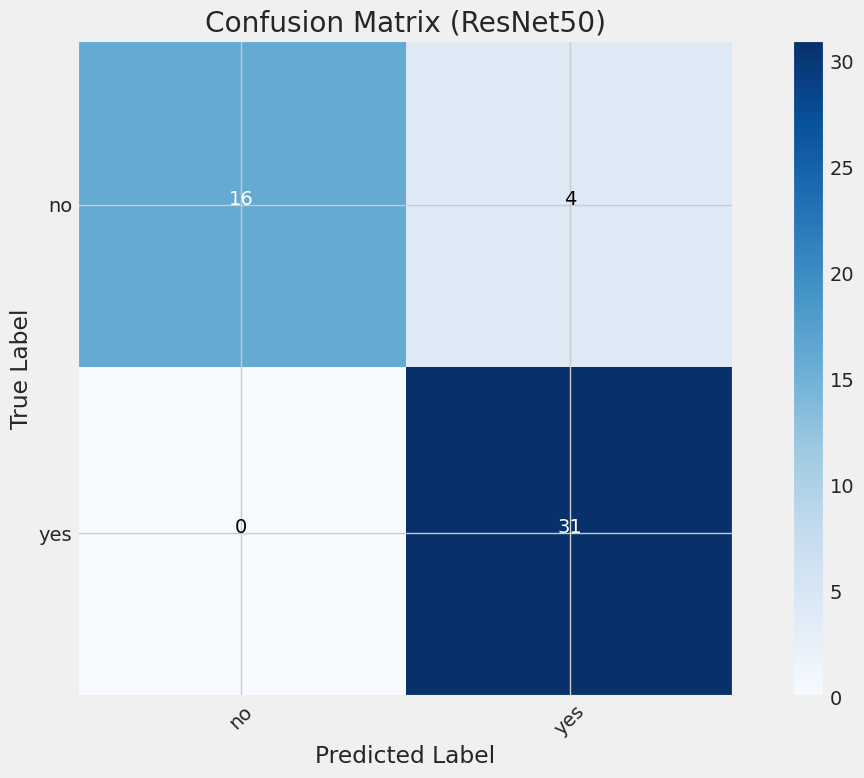

In [31]:
#  Confusion Matrix
cm = confusion_matrix(y_true_idx, y_pred_idx)
plt.figure(figsize=(12,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (ResNet50)')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [32]:
# Classification report
print("Classification Report (Test):")
print(classification_report(y_true_idx, y_pred_idx, target_names=class_names))

Classification Report (Test):
              precision    recall  f1-score   support

          no       1.00      0.80      0.89        20
         yes       0.89      1.00      0.94        31

    accuracy                           0.92        51
   macro avg       0.94      0.90      0.91        51
weighted avg       0.93      0.92      0.92        51



## ResNet50 Model Saving

In [33]:
model.save("brain_tumor_resnet50.h5")

In [34]:
print("train_gen.class_indices:", train_gen.class_indices)
inv_map = {v:k for k,v in train_gen.class_indices.items()}
print("inv_map (index->class):", inv_map)

train_gen.class_indices: {'no': 0, 'yes': 1}
inv_map (index->class): {0: 'no', 1: 'yes'}


In [36]:
preds_all = model.predict(test_eval_gen, verbose=1)
y_pred_all = np.argmax(preds_all, axis=1)
(unique, counts) = np.unique(y_pred_all, return_counts=True)
print("Predicted distribution on test set:", dict(zip(unique, counts)))
for i in range(min(10, len(preds_all))):
    print(i, preds_all[i])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted distribution on test set: {0: 16, 1: 35}
0 [0.07364383 0.92635614]
1 [0.25966868 0.7403313 ]
2 [0.22987369 0.77012634]
3 [0.18107618 0.81892383]
4 [0.1182768 0.8817232]
5 [0.09387577 0.90612423]
6 [0.14279428 0.8572057 ]
7 [0.47857174 0.5214283 ]
8 [0.201095 0.798905]
9 [0.23423328 0.7657667 ]


    threshold   prec_no  rec_no     f1_no  prec_yes   rec_yes    f1_yes  \
0        0.05  1.000000    0.05  0.095238  0.620000  1.000000  0.765432   
1        0.10  1.000000    0.15  0.260870  0.645833  1.000000  0.784810   
2        0.15  1.000000    0.25  0.400000  0.673913  1.000000  0.805195   
3        0.20  1.000000    0.30  0.461538  0.688889  1.000000  0.815789   
4        0.25  1.000000    0.35  0.518519  0.704545  1.000000  0.826667   
5        0.30  1.000000    0.55  0.709677  0.775000  1.000000  0.873239   
6        0.35  1.000000    0.70  0.823529  0.837838  1.000000  0.911765   
7        0.40  1.000000    0.70  0.823529  0.837838  1.000000  0.911765   
8        0.45  1.000000    0.75  0.857143  0.861111  1.000000  0.925373   
9        0.50  1.000000    0.80  0.888889  0.885714  1.000000  0.939394   
10       0.55  0.944444    0.85  0.894737  0.909091  0.967742  0.937500   
11       0.60  0.894737    0.85  0.871795  0.906250  0.935484  0.920635   
12       0.65  0.894737  

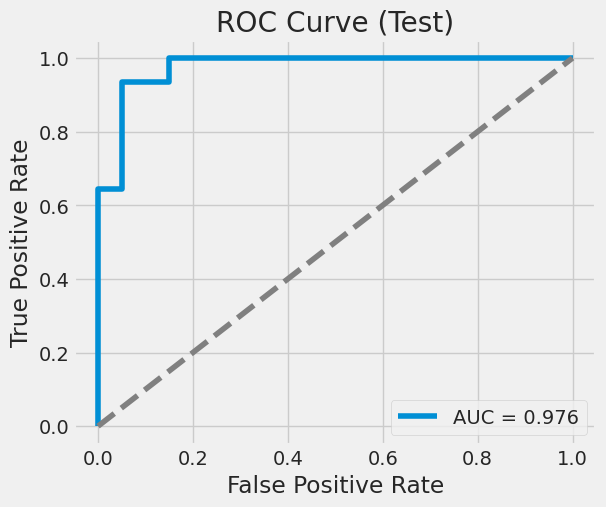

In [37]:
# ==== Threshold sweep + اختيار أفضل threshold لفئة 'yes' ====
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# preds_all, y_true (مفترض معرفين من قبل: preds_all = model.predict(test_eval_gen); y_true = test_eval_gen.classes)
# class_names معرفين أيضاً كما قبل
y_score_pos = preds_all[:, 1]   # احتمال الكلاس 'yes'
y_true = test_eval_gen.classes

thresholds = np.linspace(0.05, 0.95, 19)
rows = []
for t in thresholds:
    y_pred_t = (y_score_pos >= t).astype(int)
    prec, rec, f1, sup = precision_recall_fscore_support(y_true, y_pred_t, average=None, zero_division=0)
    # indices: 0 -> 'no', 1 -> 'yes'
    rows.append({
        'threshold': t,
        'prec_no': prec[0], 'rec_no': rec[0], 'f1_no': f1[0],
        'prec_yes': prec[1], 'rec_yes': rec[1], 'f1_yes': f1[1],
        'prec_macro': np.mean(prec), 'rec_macro': np.mean(rec), 'f1_macro': np.mean(f1)
    })

df_thresh = pd.DataFrame(rows)
# عرض كل thresholds
pd.set_option('display.max_rows', None)
print(df_thresh)

# اختاري أفضل threshold على أساس f1 لفئة 'yes' (تقدير واحد ممكن تغييره)
best_row = df_thresh.loc[df_thresh['f1_yes'].idxmax()]
best_t = best_row['threshold']
print("\nBest threshold by f1_yes:", best_t)
print(best_row)

# ======================================
# استخدمي الـ best_t لحساب confusion matrix و classification report
y_pred_best = (y_score_pos >= best_t).astype(int)
cm = confusion_matrix(y_true, y_pred_best)
print("\nConfusion Matrix (at threshold = %.2f):" % best_t)
print(cm)

print("\nClassification Report (at threshold = %.2f):" % best_t)
print(classification_report(y_true, y_pred_best, target_names=class_names))

# ارسم ROC curve وبيان التغير لو حبيت (اختياري)
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_score_pos)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test)')
plt.legend()
plt.show()

In [38]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def predict_with_threshold(img_path, model, target_size=(224,224), threshold=0.4):
   
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, target_size)

    img_array = img_resized.astype("float32") / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    probs = model.predict(img_array, verbose=0)[0]
    prob_yes = probs[1]   # احتمال tumor
    prob_no = probs[0]    # احتمال no tumor

    
    if prob_yes >= threshold:
        pred_class = "yes"
        pred_prob = prob_yes
    else:
        pred_class = "no"
        pred_prob = prob_no
 
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"Predicted: {pred_class} (Prob: {pred_prob:.2f})")
    plt.show()

    print(f"Path: {img_path}")
    print(f"Raw probs: {probs}")
    print(f"Pred class: {pred_class}, Prob: {pred_prob:.4f}")
    print("-" * 40)

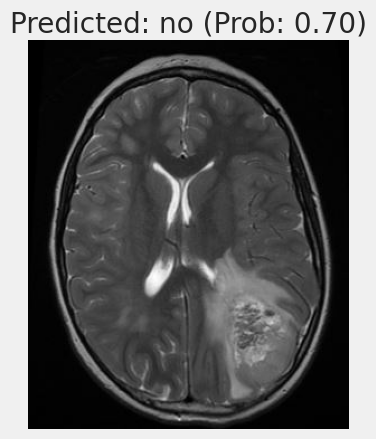

Path: /kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y100.JPG
Raw probs: [0.7003089  0.29969102]
Pred class: no, Prob: 0.7003
----------------------------------------


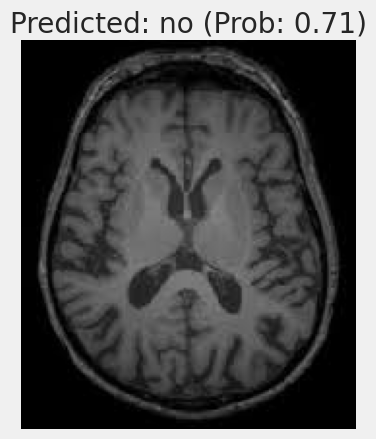

Path: /kaggle/input/brain-mri-images-for-brain-tumor-detection/no/10 no.jpg
Raw probs: [0.7125786  0.28742135]
Pred class: no, Prob: 0.7126
----------------------------------------


In [39]:
#  tumor
predict_with_threshold(
    "/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y100.JPG",
    model,
    threshold=0.4
)

#  no tumor
predict_with_threshold(
    "/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/10 no.jpg",
    model,
    threshold=0.4
)

In [40]:
#  دالة inference ثابتة تستخدم preprocess_input + threshold
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

def predict_with_threshold_preprocess(img_path, model, threshold=0.4, target_size=(224,224)):
    # load + resize
    img = image.load_img(img_path, target_size=target_size)
    img_arr = image.img_to_array(img)
    img_batch = np.expand_dims(img_arr, axis=0)
    # IMPORTANT: use same preprocess used in training
    img_batch = preprocess_input(img_batch)

    probs = model.predict(img_batch, verbose=0)[0]   # [prob_no, prob_yes]
    prob_no, prob_yes = float(probs[0]), float(probs[1])

    # decide using threshold on prob_yes
    pred_label = 'yes' if prob_yes >= threshold else 'no'
    # show image and result
    plt.imshow(image.array_to_img(img_batch[0] if False else img_arr))  # show original resized
    plt.axis('off')
    plt.title(f"Pred: {pred_label}  (yes_prob={prob_yes:.3f}, no_prob={prob_no:.3f})")
    plt.show()

    print("Path:", img_path)
    print("Raw probs: [no, yes] =", [prob_no, prob_yes])
    print(f"Predicted (threshold={threshold}):", pred_label)
    print("-"*40)
    return probs, pred_label

## ResNet50 Testing ✅✅✅

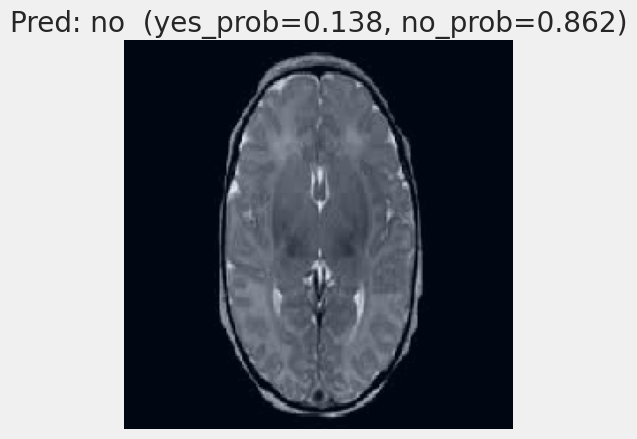

Path: /kaggle/input/brain-mri-images-for-brain-tumor-detection/no/12 no.jpg
Raw probs: [no, yes] = [0.862252414226532, 0.1377476006746292]
Predicted (threshold=0.4): no
----------------------------------------


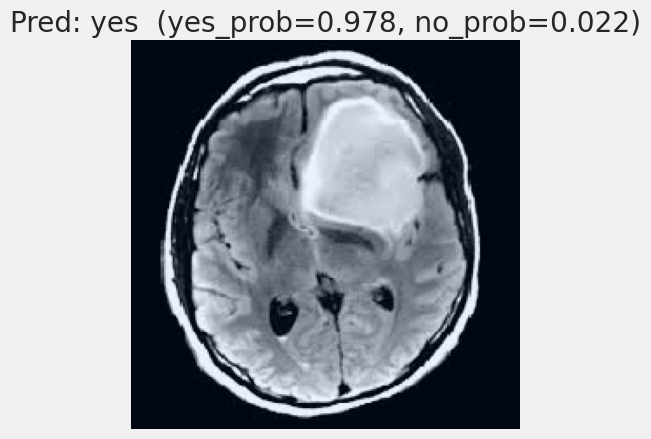

Path: /kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y105.jpg
Raw probs: [no, yes] = [0.02232641540467739, 0.9776736497879028]
Predicted (threshold=0.4): yes
----------------------------------------


In [41]:
p1, lab1 = predict_with_threshold_preprocess(
    "/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/12 no.jpg",
    model, threshold=0.4
)

p2, lab2 = predict_with_threshold_preprocess(
    "/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y105.jpg",
    model, threshold=0.4
)

## ResNet50 is better Than EfficientNetB3  